In [2]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [14]:
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from sklearn.covariance import LedoitWolf

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper

# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

In [4]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [5]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [6]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = [] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties



Available datasets are: ['train']


In [7]:
dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

In [7]:
@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
) -> Dict:
    model.eval()
    
    # Gaussian Params (from gaussian_filter, scipy)
    blurs = []
    truncate=4.0

    DSCs = {'0': []}
    for sigma in torch.linspace(0.5, 3, 5):
        DSCs[str(sigma.item())] = []
        radius = round(truncate * sigma.item())
        kernel_size = 2*radius + 1
        blurs.append(
            GaussianBlur(
                kernel_size=kernel_size,
                sigma=sigma.item()
            )    
        )

    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        # convert -1 labels to background
        target[target == -1] = 0
        # # convert to one-hot encoding
        # target = F.one_hot(
        #     target.long(), 
        #     num_classes=4
        # ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out_original = model(input_.cuda()).detach().cpu()
        segmap_original = torch.argmax(net_out_original, dim=1, keepdims=True)
        DSCs['0'].append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap_original, target)]
            ).cpu()
        )
        for blur in blurs:
            input_augmented = blur(input_)

            net_out_augmented = model(input_augmented.cuda()).detach().cpu()
            segmap_augmented = torch.argmax(net_out_augmented, dim=1, keepdims=True)
            DSCs[str(blur.sigma[1])].append(
                torch.tensor([dice(
                        s.flatten(), 
                        t.flatten(),
                        num_classes=4,
                        zero_division=1,
                        average='macro'
                    ) for s,t in zip(segmap_augmented, target)]
                ).cpu()
            )

    return DSCs


In [8]:
DSCs = eval_heart_set(
    model=unet, 
    dataloader=dataloader
)

KeyboardInterrupt: 

In [28]:
for key in DSCs:
    # DSCs[key] = torch.cat(DSCs[key])
    print(f'{key}: {DSCs[key].mean()}')


0: 0.9215230345726013
0.5: 0.9224403500556946
1.125: 0.8887324333190918
1.75: 0.8569796681404114
2.375: 0.8031411170959473
3.0: 0.7833218574523926


In [8]:
class DomainshiftAugmenter(nn.Module):
    def __init__(self, augments: List[nn.Module]):
        super(DomainshiftAugmenter, self).__init__()
        self.augments = augments
    
    def forward(self, x: Tensor):
        return [aug(x) for aug in self.augments]
    

def get_gaussian_domainshift_augments(
    sigmas: List[float],
    truncate: float = 4.0,
) -> List[nn.Module]:
    # radius = round(truncate * sigma)
    # kernel_size = 2*radius + 1

    return [
        GaussianBlur(
            kernel_size=2 * round(truncate * sigma) + 1,
            sigma=sigma
        ) for sigma in sigmas
    ]

In [8]:
# augs = get_gaussian_domainshift_augments(
#     sigmas = [0.5 * i for i in range(1, 7)]
# )

# domainshift_augmenter = DomainshiftAugmenter(augs)

In [9]:
# def get_domainshift_flips(
#     output_id: Tensor,
#     output_ood: List[Tensor],
#     net_out: str
# ):  
#     if net_out == 'brain':
#         segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
#         segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1

#     elif net_out == 'heart':
#         segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
#         segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)

#     return segmap_id != segmap_ood


In [9]:
class UMapGenerator(nn.Module):
    """
    Calculates uncertainty maps from UNets in different ways.
    
    PyTorch Module to generate uncertainty maps from
    * VAE samples
    * Entropy in drop out samples
    * Entropy in model outputs
    """
    
    def __init__(
        self,
        method: str,  # 'ae'
        net_out: str,  # 'mms' or 'calgary'
    ):
        super().__init__()
        self.method  = method
        self.net_out = net_out
        self.m       = nn.Softmax(dim=1) if net_out=='heart' else nn.Sigmoid()
        self.ce      = nn.CrossEntropyLoss(reduction='none') if net_out=='heart' else nn.BCEWithLogitsLoss(reduction='none')
        self.kld     = nn.KLDivLoss(reduction='none')
        self.mse     = nn.MSELoss(reduction='none')
    
    @torch.no_grad()
    def forward(self, x: Tensor, batch_size: int = 1) -> Tensor:
        
        if self.method == 'none':
            return None
        
        x = x.detach()

        #################################
        ### Cross and regular Entropy ###
        #################################

        if self.method == 'cross_entropy':
            umap = self.ce(x[:batch_size], self.m(x[batch_size:]))
            if len(umap.shape) == 3:
                umap = umap.unsqueeze(1)
            # umap = umap.mean(dim=1, keepdims=True)
            
        elif self.method == 'entropy':          
            x_prob = self.m(x[:batch_size])
            umap = torch.special.entr(x_prob).sum(dim=1, keepdims=True)
            # umap = torch.distributions.Categorical(x_prob.permute(0,2,3,1)).entropy().unsqueeze(1)

        elif self.method == 'top2diff':
            x_prob = self.m(x[:batch_size])
            assert len(x_prob.shape) == 4, f"x_prob shape is {x_prob.shape}, but should be (n, c, h, w)"
            x_prob_sorted, _ = x_prob.sort(1)
            umap = 1 - (x_prob_sorted[:, -1:] - x_prob_sorted[:, -2:-1])
            assert len(umap.shape) == 4, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"

        elif self.method == 'kld_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_augmented_log_prob = torch.log(output_augmented_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            kld = self.kld(output_augmented_log_prob, output_prob).sum(dim=1, keepdims=True)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = entropy * kld

        elif self.method == 'mse_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_augmented_log_prob = torch.log(output_augmented_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            mse = self.mse(output_prob, output_augmented_prob).mean(dim=1, keepdims=True)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = entropy * mse

        elif self.method == 'centr_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            ce = self.ce(output_prob, output_augmented_prob).unsqueeze(1)#.sum(dim=1, keepdims=True)
            umap = entropy * ce

        elif self.method == 'diff_grad':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            predicted_class_prob, index_of_class = output_prob.max(dim=1, keepdim=True)
            diff_to_pred = predicted_class_prob - output_prob
            diff_to_pred_augmented = torch.gather(output_augmented_prob, 1, index_of_class) - output_augmented_prob
            umap = (diff_to_pred - diff_to_pred_augmented) / torch.max(diff_to_pred, torch.ones_like(diff_to_pred) * 1e7)
            umap = torch.amax(umap, dim=1, keepdim=True)

        #################################
        ### experimental / M&M only   ###
        #################################
    
        elif self.method == 'kl_divergence':
            x_in = F.log_softmax(x[:batch_size], dim=1)
            umap = self.kl(x_in, self.m(x[batch_size:]))
            umap = umap.sum(dim=(1), keepdims=True)
            
        elif self.method == 'mse':
            x      = self.m(x)
            x     -= x.min(dim=1, keepdims=True).values
            x     /= x.sum(dim=1, keepdims=True)
            umap   = torch.pow(x[:batch_size] - x[batch_size:], 2).mean(1, keepdim=True)

        
        assert umap.shape[1] == 1, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"
        return umap

In [10]:
from torch.utils.data import Dataset
from typing import List, Dict, Union
# from utils import UMapGenerator
from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc

def get_precision_recall_for_domainshift_flips(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        model.set_transform(False)
        output_id = model(input_)
        output_ood = model(input_augmented)
        model.set_transform(True)
        output_ood_transformed = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                torch.cat([output_ood, output_ood_transformed], dim=0).cpu(), 
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc




@torch.no_grad()
def get_precision_recall_for_domainshift_flips_model(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    dae: bool,
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    if dae == True:
        # Remove trainiung hooks, add evaluation hooks
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device[0])
        model.freeze_seg_model()
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        output_id = model(input_)
        output_ood = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                output_ood,
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc

In [44]:

class PoolingMahalanobisDetector(nn.Module):
    def __init__(
        self,
        swivel: str,
        pool: str = 'avg2d',
        sigma_algorithm: str = 'default',
        transform: bool = False,
        lr: float = 1e-3,
        device: str  = 'cuda:0'
    ):
        super().__init__()
        # init args
        self.swivel = swivel
        self.pool = pool
        self.sigma_algorithm = sigma_algorithm
        # self.hook_fn = self.register_forward_pre_hook if hook_fn == 'pre' else self.register_forward_hook
        self.transform = transform
        self.lr = lr
        self.device = device
        # other attributes
        self.training_representations = []
        # methods
        if self.pool == 'avg2d':
            self._pool = nn.AvgPool2d(
                kernel_size=(2,2), 
                stride=(2,2)
            )
        elif self.pool == 'avg3d':
            self._pool = nn.AvgPool3d(
                kernel_size=(2,2,2),
                stride=(2,2,2)
            )
        self.to(device)


    ### private methods ###

    def _reduce(self, x: Tensor) -> Tensor:
        if 'avg' in self.pool:
            # reduce dimensionality with 3D pooling to below 1e4 entries
            while torch.prod(torch.tensor(x.shape[1:])) > 1e4:
                x = self._pool(x)
            x = self._pool(x)
        elif self.pool == 'none':
            pass
        # reshape to (batch_size, 1, n_features)
        x = x.reshape(x.shape[0], 1, -1)
        return x


    @torch.no_grad()
    def _collect(self, x: Tensor) -> None:
        # reduces dimensionality, moves to cpu and stores
        
        x = self._reduce(x.detach()).cpu()
        self.training_representations.append(x)


    @torch.no_grad()
    def _merge(self) -> None:
        # concatenate batches from training data
        self.training_representations = torch.cat(
            self.training_representations,
            dim=0
        )


    @torch.no_grad()
    def _estimate_gaussians(self) -> None:
        self.mu = self.training_representations.mean(0, keepdims=True).detach().to(self.device)
        
        if self.sigma_algorithm == 'diagonal':
            self.register_buffer(
                'var',
                torch.var(self.training_representations.squeeze(1), dim=0)
            )
            self.register_buffer(
                'sigma_inv', 
                1 / torch.sqrt(self.var).to(self.device)
            )
        
        elif self.sigma_algorithm == 'default':
            self.register_buffer(
                'sigma',
                torch.cov(self.training_representations.squeeze(1).T)
            )
            self.register_buffer(
                'sigma_inv', 
                torch.linalg.inv(self.sigma).detach().unsqueeze(0).to(self.device)
            )

        elif self.sigma_algorithm == 'ledoitWolf':
            self.register_buffer(
                'sigma', 
                torch.from_numpy(
                    LedoitWolf().fit(
                        self.training_representations.squeeze(1)
                    ).covariance_
                )
            )
            self.register_buffer(
                'sigma_inv', 
                torch.linalg.inv(self.sigma).detach().unsqueeze(0).to(self.device)
            )

        else:
            raise NotImplementedError('Choose from: lediotWolf, diagonal, default')


    def _distance(self, x: Tensor) -> Tensor:
        assert self.sigma_inv is not None, 'fit the model first'
        # assert self.device == x.device, 'input and model device must match'
        x_reduced  = self._reduce(x)
        x_centered = x_reduced - self.mu
        if self.sigma_algorithm == 'diagonal':
            dist  = x_centered**2 * self.sigma_inv
        else:
            dist = x_centered @ self.sigma_inv @ x_centered.permute(0,2,1)

        return torch.sqrt(dist)


    ### public methods ###

    def fit(self):
        self._merge()
        self._estimate_gaussians()
        del self.training_representations


    def forward(self, x: Tensor) -> Tensor:
        # implements identity function from a hooks perspective
        if self.training:
            self._collect(x)
        
        else:
            self.batch_distances = self._distance(x).detach().view(-1)
            if self.transform:
                x = x.clone().detach().requires_grad_(True)
                dist = self._distance(x).mean()
                dist.backward()
                x.data.sub_(self.lr * x.grad.data)
                x.grad.data.zero_()
                x.requires_grad = False

        return x
    

def get_pooling_mahalanobis_detector(
    swivels: List[str],
    unet: nn.Module = None,
    pool: str = 'avg2d',
    sigma_algorithm: str = 'default',
    fit: str  = 'raw', # None, 'raw', 'augmented'
    iid_data: DataLoader = None,
    transform: bool = False,
    lr: float = 1e-3,
    device: str  = 'cuda:0',
): 
    pooling_detector = [
        PoolingMahalanobisDetector(
            swivel=swivel,
            device=device,
            pool=pool,
            sigma_algorithm=sigma_algorithm,
            transform=transform,
            lr=lr,
        ) for swivel in swivels
    ]
    pooling_wrapper = PoolingMahalanobisWrapper(
        model=unet,
        adapters=nn.ModuleList(pooling_detector)
    )
    pooling_wrapper.hook_adapters()
    pooling_wrapper.to(device)
    if fit == 'raw':
        for batch in iid_data:
            x = batch['input'].to(device)
            _ = pooling_wrapper(x)
    elif fit == 'augmented':
        for _ in range(250):
            batch = next(iid_data)
            x = batch['data'].to(device)
            _ = pooling_wrapper(x)
    if fit is not None:
        pooling_wrapper.fit()
        pooling_wrapper.eval()

    return pooling_wrapper

In [45]:
augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)


In [47]:

augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)


mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=['up3.0.conv_path.0.bn'],
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    lr=5e1,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.00047782366164028645


KeyboardInterrupt: 

In [20]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='top2diff',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.36562836170196533
1.0: 0.36421477794647217
1.5: 0.37277212738990784
2.0: 0.3868952691555023
2.5: 0.3966067135334015
3.0: 0.40939992666244507


In [17]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='diff_grad',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.052302081137895584
1.0: 0.3019622564315796
1.5: 0.35226690769195557
2.0: 0.3830333352088928
2.5: 0.4489980936050415
3.0: 0.5092993974685669


In [42]:


augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)


mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=['up3.0.conv_path.0.bn'],
    unet=unet,
    sigma_algorithm='default',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    lr=5e1,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.20214003324508667
1.0: 0.31817156076431274
1.5: 0.3500712513923645
2.0: 0.3798588812351227
2.5: 0.39080309867858887
3.0: 0.3968576192855835


In [60]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=1e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.203425794839859
1.0: 0.332897812128067
1.5: 0.3726859390735626
2.0: 0.407044917345047
2.5: 0.42340371012687683
3.0: 0.4345472753047943


0.5: 0.193344846367836
1.0: 0.35372355580329895
1.5: 0.4085277318954468
2.0: 0.4560043513774872
2.5: 0.5190661549568176
3.0: 0.5780220627784729


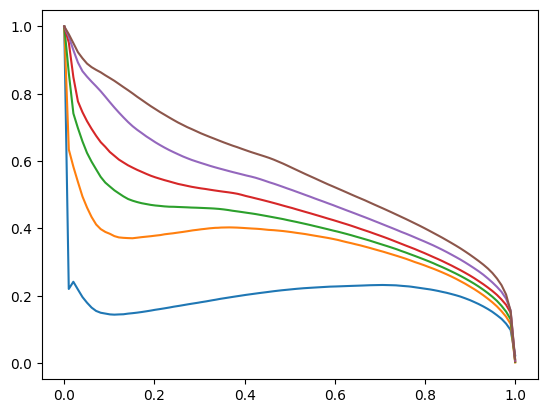

In [31]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")
    plt.plot(r, p, label=f'{aug.sigma[1]}')

plt.show()

In [23]:
for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips_model(
        model=unet, 
        dataset=data['train'], 
        net_out='heart', 
        umap='entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        dae=False,
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

KeyboardInterrupt: 

500000.0: 0.4209441840648651
800000.0: 0.42596468329429626
1000000.0: 0.4252321720123291
3000000.0: 0.36881452798843384
5000000.0: 0.2993611991405487


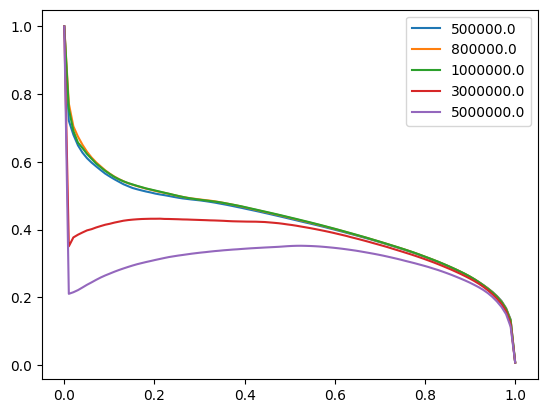

In [28]:
swivels = ['up3.0.conv_path.0.bn']



for lr in [5e5, 8e5, 1e6, 3e6, 5e6]:
    mahalanobis_detector = get_batchnorm_mahalanobis_detector(
        swivels=swivels,
        unet=unet,
        reduce=False,
        aggregate='mean',
        transform=True,
        lr=lr,
        device='cuda:0'
    )
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=augs[4],
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{lr}: {pr_auc}")
    plt.plot(r, p, label=f'{lr}')

plt.legend()
plt.show()

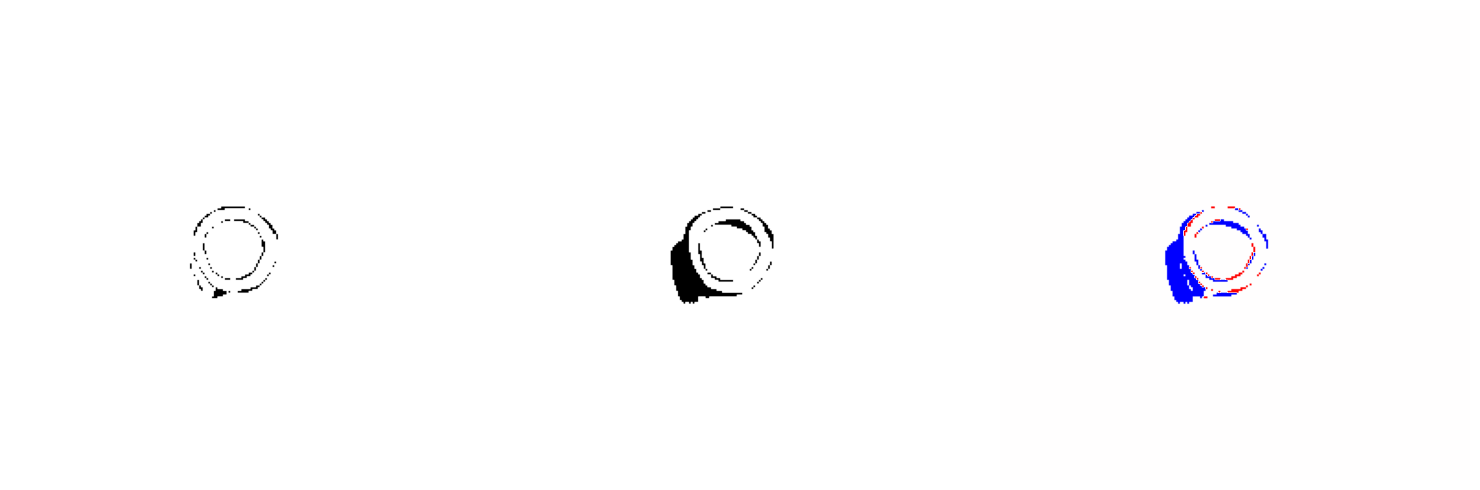

In [124]:
idx = 17


truncate = 4
sigma = 3
radius = round(truncate * sigma)
kernel_size = 2*radius + 1
augmenter = GaussianBlur(
    kernel_size=kernel_size,
    sigma=sigma
)    

ds = data['train'][idx]
img = ds['input']
img_augmented = augmenter(img.unsqueeze(0)).squeeze(0)
target = ds['target'].unsqueeze(0)
target[target == -1] = 0
out = unet(
    torch.stack([img, img_augmented], dim=0).cuda()
).detach().cpu()
segmap = torch.argmax(out, dim=1, keepdims=True)
errmap = (segmap != target).squeeze()

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(errmap[0], cmap='Greys')
axes[1].imshow(errmap[1], cmap='Greys')
axes[2].imshow(errmap[0]*1 - errmap[1]*1, cmap='bwr')

for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

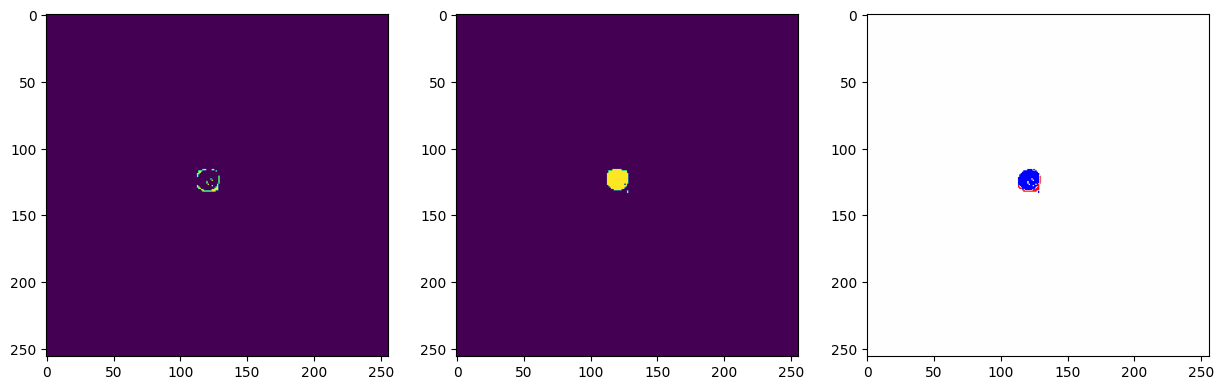

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(errmap[0])
ax[1].imshow(errmap[1])
ax[2].imshow(errmap[0]*1 - errmap[1]*1, cmap='bwr')

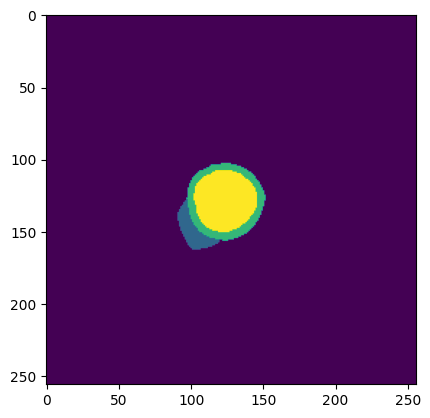

In [91]:
plt.imshow(segmap[0].squeeze().numpy())

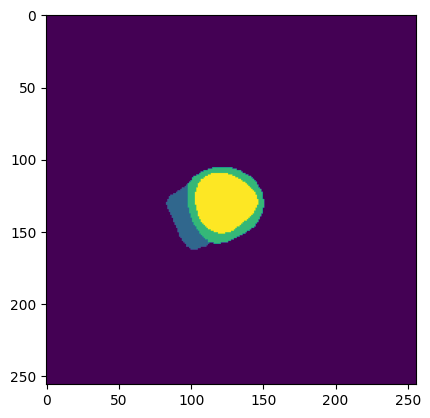

In [92]:
plt.imshow(segmap[1].squeeze().numpy())

In [ ]:
## Original Augmentation + Params from Batchgenerators

# input_augmented = augment_gaussian_blur(
#     data_sample=input_ ,
#     sigma_range=sigma,
#     per_channel=True,
#     p_per_channel=1,
#     different_sigma_per_axis=False,
#     p_isotropic=0
# )

## Original Eval Function

# @torch.no_grad()
# def eval_heart_set(
#     model: nn.Module, 
#     dataloader: DataLoader, 
#     eval_metrics: Dict
# ) -> Dict:
#     model.eval()
#     epoch_metrics = {key: [] for key in eval_metrics.keys()}
#     # saves batch sizes for each batch for averaging
#     batch_sizes = []
#     for batch in dataloader:
#         input_ = batch['input']
#         target = batch['target'].cuda()
#         # convert -1 labels to background
#         target[target == -1] = 0
#         # convert to one-hot encoding
#         target = F.one_hot(
#             target.long(), 
#             num_classes=4
#         ).squeeze(1).permute(0,3,1,2)
#         # get model output
#         net_out = model(input_.cuda())
        
#         batch_sizes.append(input_.shape[0])
#         for key, metric in eval_metrics.items():
#             epoch_metrics[key].append(
#                 metric(net_out, target).detach().mean().cpu()
#             )
            
#     for key, epoch_scores in epoch_metrics.items():
#         epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
        
#     return epoch_metrics

In [18]:
preds = torch.randn(2, 4, 32, 32)
values, indices = preds.max(dim=1, keepdim=True)

In [21]:
torch.gather(preds, 1, indices).shape

torch.Size([2, 1, 32, 32])

In [17]:
predicted_class

torch.return_types.max(
values=tensor([[[[-4.8880e-01,  7.6606e-01,  1.3431e+00,  ...,  8.1411e-01,
           -5.6032e-01,  5.1103e-01],
          [-1.2172e-01,  4.8081e-01,  6.8901e-01,  ...,  8.9007e-01,
            1.1506e+00,  1.4276e+00],
          [ 9.1435e-01,  2.9793e+00,  5.2600e-01,  ..., -3.0301e-01,
            1.1890e+00,  1.2451e+00],
          ...,
          [ 8.9925e-01,  2.0274e+00,  2.5121e+00,  ..., -1.7270e-01,
            3.7108e-01,  1.4976e+00],
          [ 1.4235e+00,  8.6231e-01,  1.1251e+00,  ...,  1.5718e+00,
            7.7728e-01,  5.6269e-01],
          [ 2.2064e-01,  6.5947e-01,  1.2615e+00,  ...,  9.4897e-01,
            1.3777e+00,  1.6679e+00]]],


        [[[ 1.8127e+00,  3.1577e-01,  1.5697e+00,  ...,  8.4483e-01,
            1.2458e+00,  4.8804e-01],
          [ 2.8106e+00,  6.5744e-01,  8.8956e-01,  ...,  1.6904e+00,
            1.0160e+00,  2.8760e+00],
          [ 8.5902e-01,  1.4587e+00,  6.0196e-01,  ...,  1.4281e+00,
            1.1130e+00,  